In [ ]:
#######################################
#Titanic Data Machine Learning Models#
#           Heqiao Ruan              #
#    Department of Statistics        #
#          Genome Center             #
#   University of California, Davis  #
######################################


In [1]:
import math
import os
import numpy as np
import re
import pandas as pd
import sklearn
import joblib
from joblib import dump, load
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import imblearn
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

import scipy
from scipy import stats 
from scipy.stats import norm
from scipy.stats import skew
from scipy.special import boxcox1p
import matplotlib.pyplot as plot


import keras
from keras import Sequential
from keras import backend as K
from keras import losses
from keras.models import Model
from keras.models import load_model
from keras.layers import average, LeakyReLU, Conv2D, UpSampling2D, MaxPooling2D
from keras.layers import Input, BatchNormalization
from keras.layers import Dense
from keras.layers import Lambda, Input, Dense, Dropout,GaussianNoise,Lambda,Flatten,Activation,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.models import Model
from keras.optimizers import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

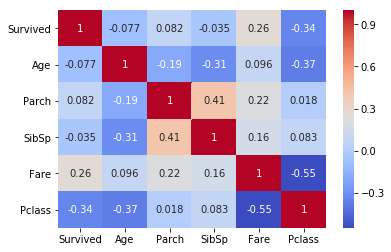

In [6]:
#correlation among numerical features, no major correlation except Fare:
g = sns.heatmap(train_df[['Survived','Age','Parch','SibSp','Fare','Pclass']].corr(), annot = True,
               cmap = 'coolwarm')

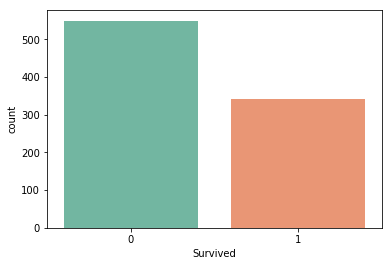

In [7]:
#Draw the histogram/ distribution plot for each of the variable:
sns.countplot(train_df['Survived'], palette = 'Set2')

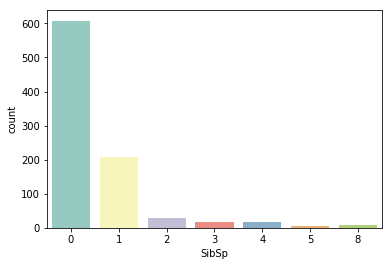

In [8]:
sns.countplot(train_df['SibSp'], palette = 'Set3')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


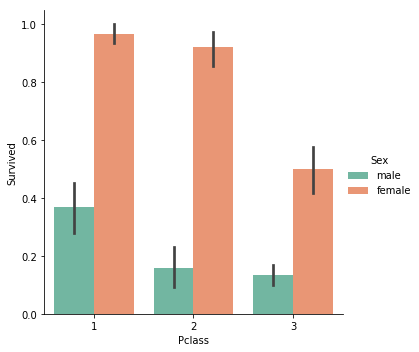

In [9]:
sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train_df, kind = 'bar', palette = 'Set2')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


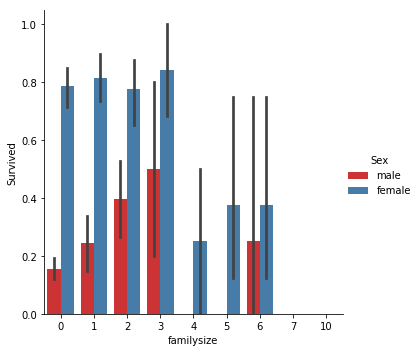

In [10]:
#Test the family size influence:
train_df['familysize'] = train_df['SibSp'] + train_df['Parch']
sns.factorplot(x = 'familysize', y = 'Survived', hue = 'Sex', data = train_df, kind = 'bar', palette = 'Set1')

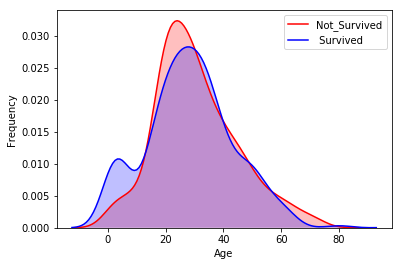

In [11]:
#Investigate the age pattern:
plt = sns.kdeplot(train_df['Age'][(train_df['Survived'] == 0) & (train_df['Age'].notnull())], color = 'Red', shade = True)
plt = sns.kdeplot(train_df['Age'][(train_df['Survived'] == 1) & (train_df['Age'].notnull())], color = 'Blue', shade = True)
plt.set_xlabel('Age')
plt.set_ylabel('Frequency')
plt.legend(['Not_Survived', ' Survived'])


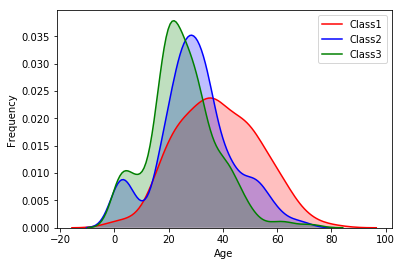

In [12]:
#Investigate the pattern of different class with age
plt = sns.kdeplot(train_df['Age'][(train_df['Pclass'] == 1) & (train_df['Age'].notnull())], color = 'Red', shade = True)
plt = sns.kdeplot(train_df['Age'][(train_df['Pclass'] == 2) & (train_df['Age'].notnull())], color = 'Blue', shade = True)
plt = sns.kdeplot(train_df['Age'][(train_df['Pclass'] == 3) & (train_df['Age'].notnull())], color = 'Green', shade = True)
plt.set_xlabel('Age')
plt.set_ylabel('Frequency')
plt.legend(['Class1','Class2','Class3'])



In [13]:
#Detect obvious outliers:
#Select the observations following 3 different features are identified as outliers:
def detecting_outliers(df, s, features):
    outlier_index = []
    for feature in features:
        quan1 = np.percentile(df[feature], 25)
        quan2 = np.percentile(df[feature], 75)
        iqr = quan2 - quan1
        outliers_diff = 2*iqr
        indices_diff = df[(df[feature] < quan1 - 1.5*iqr) | (df[feature] > quan2 + 1.5*iqr)].index
        outlier_index.extend(indices_diff)
    outliers = Counter(outlier_index)
    multiple_outliers = list(k for k, v in outliers.items() if v > s)
    return multiple_outliers
outlier_to_drop = detecting_outliers(train_df, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [16]:
#Drop the outliers!
outlier_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [17]:
#Remove the outliers!
train_df = train_df.drop(outlier_to_drop, axis = 0).reset_index(drop = True)

In [18]:
#Fill the na with mean value:
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


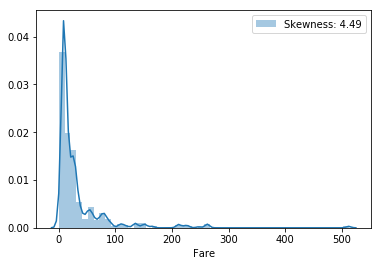

In [19]:
#Investigate the fare distribution:
whole = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)
plt = sns.distplot(whole['Fare'], label = "Skewness: %.2f"%(whole['Fare'].skew()))
plt = plt.legend(loc = 'best')

In [20]:
whole['Fare'].min()

0.0

In [21]:
Fare = whole['Fare'].map(lambda X: np.log(X) if X>0 else 0)

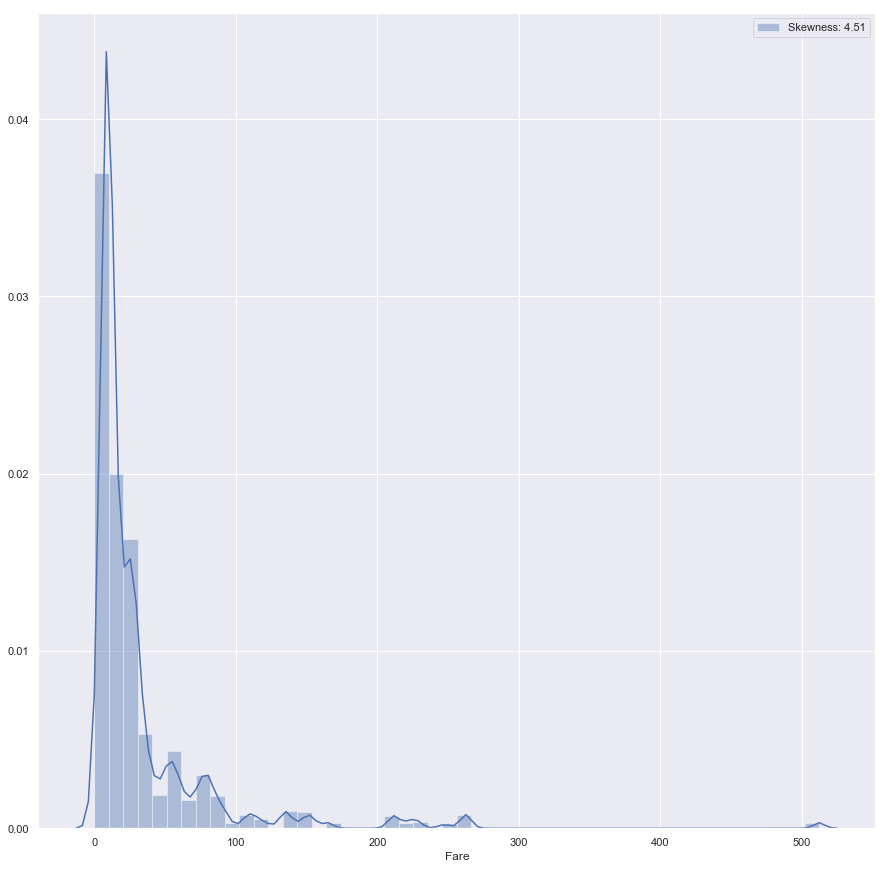

In [2319]:
plt = sns.distplot(whole['Fare'], label = 'Skewness: %.2f'%(whole['Fare'].skew()))
plt = plt.legend(loc = 'best')

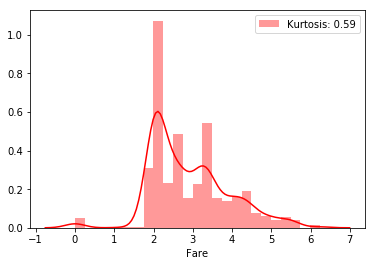

In [22]:
#Try log transformation to reduce the skewness:
plt = sns.distplot(Fare, label = 'Kurtosis: %.2f'%(Fare.kurtosis()), color = 'r')
plt = plt.legend(loc = 'best')

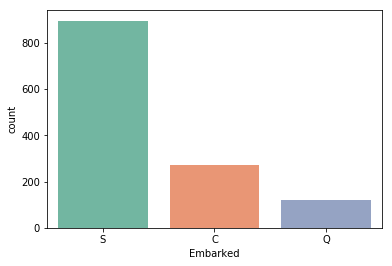

In [23]:
sns.countplot(whole['Embarked'], palette = 'Set2')

In [24]:
#Fill the Embarked missing value as S:
whole['Embarked'] = whole['Embarked'].fillna("S")

In [25]:
whole['Family_size'] = whole['SibSp'] + whole['Parch'] + 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. N

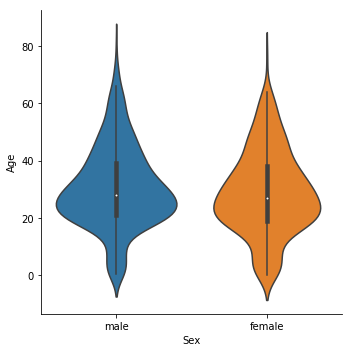

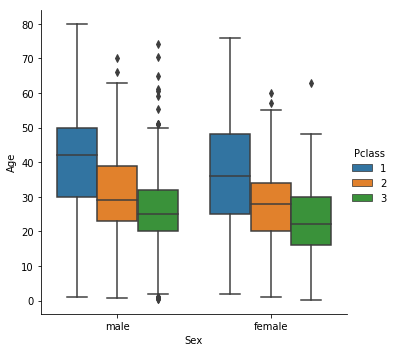

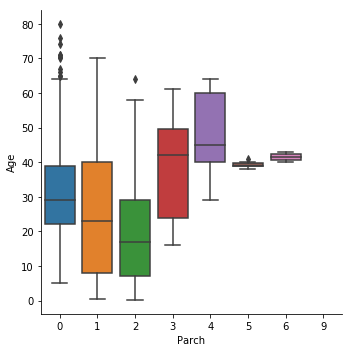

In [26]:
#Impute the missing values:
#For Ages:
sns.factorplot(x = 'Sex', y ='Age', kind = 'violin', data = whole)
sns.factorplot(x = 'Sex', y = 'Age', hue = 'Pclass', kind = 'box', data = whole)
sns.factorplot(x = 'Parch', y = 'Age', kind = 'box', data = whole)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


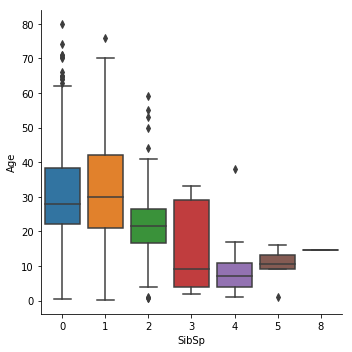

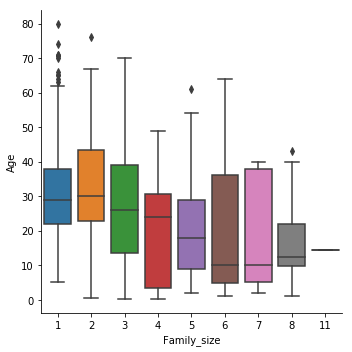

In [27]:
sns.factorplot(x = 'SibSp', y = 'Age', kind = 'box', data = whole)
sns.factorplot(x = 'Family_size', y ='Age', kind = 'box', data = whole)

In [28]:
whole['Fare'] = whole['Fare'].map(lambda X: np.log(X) if X>0 else 0)

In [29]:
#We want to reimpute the age variable:
#Impute the age as the median of the similar guy in terms of SibSp, Parch, Pclass, if no similar guy, use the sample median
index_age_NAN = list(whole['Age'][whole['Age'].isnull()].index)
for index in index_age_NAN:
    age_median = whole['Age'].median()
    age_prediction = whole['Age'][(whole['SibSp'] == whole.iloc[index]['SibSp']) & (
    whole['Parch'] == whole.iloc[index]['Parch']) & (whole['Pclass'] == whole.iloc[index]['Pclass'])].median()
    if np.isnan(age_prediction):
        whole['Age'].iloc[index] = age_median
    else:
        whole['Age'].iloc[index] = age_prediction

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [30]:
#Impute the Cabin:
whole['Title'] = whole['Name'].apply(lambda X: X.split(',')[1].split('.')[0].strip())

In [31]:
#Categorize familysize:
whole['Small_Family'] = whole['Family_size'].map(lambda X: 1 if X == 1 else 0)
whole['Medium_Family'] = whole['Family_size'].map(lambda X: 1 if 2<= X <= 4 else 0)
whole['Large_Family'] = whole['Family_size'].map(lambda X: 1 if X >= 5 else 0)

In [32]:
whole = whole.drop(['Family_size'], axis = 1)

In [33]:
# Convert to categorical values Title 
whole["Title"] = whole["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
whole["Title"] = whole["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
whole["Title"] = whole["Title"].astype(int)


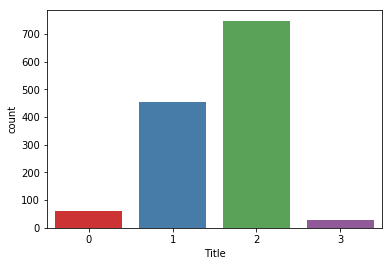

In [34]:
#Title vs. survival counts:
sns.countplot(whole['Title'], palette = 'Set1')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


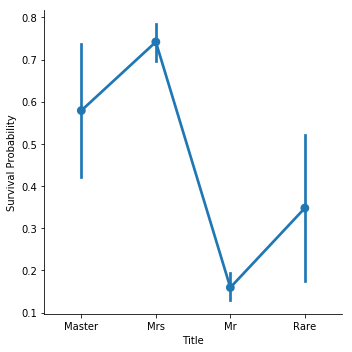

In [35]:
#title vs Survival Prob:
g = sns.factorplot(x = 'Title', y = 'Survived', data = whole)
g.set_xticklabels(['Master','Mrs','Mr','Rare'])
g.set_ylabels('Survival Probability')

In [36]:
whole = pd.get_dummies(whole, columns = ['Title'], prefix = 'Titles')

In [37]:
whole = whole.drop(labels = ['Name'], axis = 1)

In [38]:
whole['Cabin'] = pd.concat([train_df,test_df], axis = 1).reset_index(drop = True)['Cabin']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


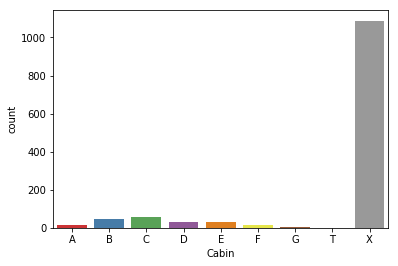

In [39]:
whole['Cabin'][whole['Cabin'].isnull()] = 'X'
whole['Cabin'] = whole['Cabin'].apply(lambda t: t[0])
sns.countplot(whole['Cabin'], palette = 'Set1', order = ['A', 'B', 'C', 'D', 'E', 'F','G','T', 'X'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


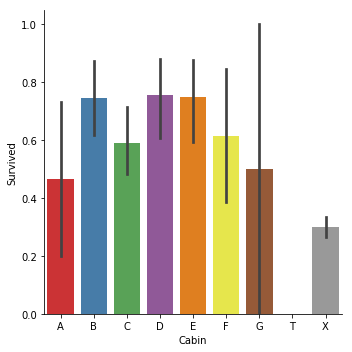

In [40]:
sns.factorplot(x = 'Cabin', y = 'Survived', kind = 'bar', palette = 'Set1', data = whole, order = ['A', 'B', 'C', 'D', 'E', 'F','G','T', 'X'])


In [41]:
#Transform the ticket feature to number:
ticket = []
for ti in whole['Ticket']:
    if not ti.isdigit():
        ticket.append(ti.replace('.','').replace('/','').split(' ')[0][0])
    else:
        ticket.append('X')
whole['Ticket'] = ticket

In [42]:
whole = pd.get_dummies(whole, columns = ['Ticket'], prefix = 'Tic')

In [43]:
#Construct a dummy variable of Cabin:
whole = pd.get_dummies(whole, columns = ['Cabin'], prefix = 'Cabin')

In [44]:
whole = whole.drop(['PassengerId'], axis = 1)
whole = pd.get_dummies(whole, columns = ['Embarked'], prefix = 'Embark')

In [45]:
whole = pd.get_dummies(whole, columns = ['Sex'], prefix = 'Sex')

In [46]:
whole = pd.get_dummies(whole, columns = ['Pclass'], prefix = 'PC')

In [47]:
#We have categorize the family size into 3, thus remove the familysize feature
whole = whole.drop(['familysize'], axis = 1).reset_index(drop = True)

In [51]:
whole.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'Survived', 'Small_Family',
       'Medium_Family', 'Large_Family', 'Titles_0', 'Titles_1', 'Titles_2',
       'Titles_3', 'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S',
       'Tic_W', 'Tic_X', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embark_C', 'Embark_Q',
       'Embark_S', 'Sex_female', 'Sex_male', 'PC_1', 'PC_2', 'PC_3'],
      dtype='object')

In [52]:
#Scaling the data by robustscaler(robust to extreme values:)
from sklearn.preprocessing import StandardScaler
sc = RobustScaler()
whole_scaled = whole
whole_scaled[['Age', 'Fare']] = sc.fit_transform(whole_scaled[['Age', 'Fare']])

In [53]:
whole_scaled.head()

,Age,Fare,Parch,SibSp,Survived,Small_Family,Medium_Family,Large_Family,Titles_0,Titles_1,...,Cabin_T,Cabin_X,Embark_C,Embark_Q,Embark_S,Sex_female,Sex_male,PC_1,PC_2,PC_3
0,-0.266667,-0.504501,0,1,0.0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,1
1,0.800000,1.166724,0,1,1.0,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2,0.000000,-0.439411,0,0,1.0,1,0,0,0,1,...,0,1,0,0,1,1,0,0,0,1
3,0.600000,0.951403,0,1,1.0,0,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
4,0.600000,-0.427968,0,0,0.0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [54]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
5                330877
6                 17463
7                349909
8                347742
9                237736
10              PP 9549
11               113783
12            A/5. 2151
13               347082
14               350406
15               248706
16               382652
17               244373
18               345763
19                 2649
20               239865
21               248698
22               330923
23               113788
24               349909
25               347077
26                 2631
27               349216
28             PC 17601
29             PC 17569
             ...       
841                2629
842              350026
843               28134
844               17466
845              233866
846              236852
847       SC/PARIS 2149
848            PC 17590
849              345777
850              347742
851             

In [55]:
#Check our scaled model:
whole_scaled.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'Survived', 'Small_Family',
       'Medium_Family', 'Large_Family', 'Titles_0', 'Titles_1', 'Titles_2',
       'Titles_3', 'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S',
       'Tic_W', 'Tic_X', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embark_C', 'Embark_Q',
       'Embark_S', 'Sex_female', 'Sex_male', 'PC_1', 'PC_2', 'PC_3'],
      dtype='object')

In [56]:
train_len = len(train_df)
train = whole_scaled.loc[:train_len-1]
test = whole_scaled.loc[train_len:]

In [60]:
X_train = train.drop(['Survived'], axis = 1)
Y_train = train['Survived']
X_test = test.drop(['Survived'], axis = 1)

In [62]:
whole.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'Survived', 'Small_Family',
       'Medium_Family', 'Large_Family', 'Titles_0', 'Titles_1', 'Titles_2',
       'Titles_3', 'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S',
       'Tic_W', 'Tic_X', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embark_C', 'Embark_Q',
       'Embark_S', 'Sex_female', 'Sex_male', 'PC_1', 'PC_2', 'PC_3'],
      dtype='object')

In [63]:
sub_features = ['Age', 'Fare', 'Parch', 'SibSp', 'Small_Family',
       'Medium_Family', 'Large_Family', 'Titles', 'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S',
       'Tic_W', 'Tic_X','Sex_female', 'Sex_male', 'PC_1', 'PC_2',
       'PC_3']
sub_cate_f = ['Small_Family',
       'Medium_Family', 'Large_Family',  'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S',
       'Tic_W', 'Tic_X','Sex_female', 'Sex_male', 'PC_1', 'PC_2',
       'PC_3', '']

In [64]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train, Y_train, test_size = 0.2)

In [65]:
X_train.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'Small_Family', 'Medium_Family',
       'Large_Family', 'Titles_0', 'Titles_1', 'Titles_2', 'Titles_3', 'Tic_A',
       'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P', 'Tic_S', 'Tic_W', 'Tic_X',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embark_C', 'Embark_Q', 'Embark_S',
       'Sex_female', 'Sex_male', 'PC_1', 'PC_2', 'PC_3'],
      dtype='object')

In [66]:
cate_f = ['Small_Family', 'Medium_Family',
       'Large_Family', 'Titles_0', 'Titles_1', 'Titles_2', 'Titles_3',
       'Adults',  'Tic_A', 'Tic_C', 'Tic_F', 'Tic_L', 'Tic_P',
       'Tic_S', 'Tic_W', 'Tic_X', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embark_C',
       'Embark_Q', 'Embark_S', 'Sex_female', 'Sex_male', 'PC_1', 'PC_2',
       'PC_3']

####################################
###  Now starts the model fitting.
#####################################

In [70]:
#Random_Forest:
#Do 10 fold gridsearchcv:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5, 6, 7, 8, 9, 10],
              "max_features": [5, 8, 10],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [3, 10],
              "bootstrap": [True, False],
              "n_estimators" :[400,800],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 41.1min finished


0.8335246842709529

In [71]:
rf_best_model = RFC_best.fit(X_train, Y_train)

In [72]:
rf_prediction_best = rf_best_model.predict(X_test)

In [73]:
dump(rf_best_model, 'rf_best_model.joblib')

['rf_best_model.joblib']

In [74]:
importance_rf = pd.DataFrame(rf_best_model.feature_importances_, index = X_train.columns, columns = ['Importance'])

In [75]:
importance_rf["Std"] = np.std([rf_best_model.feature_importances_
                            for tree in rf_best_model.estimators_], axis=0)

In [76]:
#Variable Importance:
importance_rf.sort_values(by = 'Importance', ascending = False).head(n = 10)

,Importance,Std
Titles_2,0.169117,1.776357e-15
Sex_male,0.146540,1.748601e-15
Sex_female,0.145650,1.776357e-15
Titles_1,0.113236,4.996004e-16
Fare,0.075480,9.020562e-16
PC_3,0.062114,3.747003e-16
Age,0.040118,9.714451e-17
Cabin_X,0.037099,4.302114e-16
PC_1,0.030137,2.706169e-16
Large_Family,0.028310,1.249001e-16


In [77]:
#Naive Decision Tree:
param_decitre = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'min_samples_split' : [4, 6, 8, 10, 12],
    'max_features': [0.4, 0.6, 0.8, 1],
}
dectre_clasf = GridSearchCV(DecisionTreeClassifier(), param_grid = param_decitre, cv = kfold, scoring = 'accuracy')
dectre_clasf.fit(X_train, Y_train)
decision_tree_best = dectre_clasf.best_estimator_
dectre_clasf.best_score_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8254879448909299

In [78]:
decision_tree_best_model = decision_tree_best.fit(X_train, Y_train)
decitree_prediction_best = decision_tree_best_model.predict(X_test)

In [79]:
#Gradient Boosting:
params_gradb = {
	'n_estimators': [300, 500, 700],
	'max_features': [0.3, 0.5, 0.7],
	'max_depth': [3, 5, 7, 9],
	'min_samples_leaf': [2, 4, 6]
}
gradb_clasf = GridSearchCV(GradientBoostingClassifier(), param_grid = params_gradb, cv = kfold, scoring = 'accuracy')
gradb_clasf.fit(X_train, Y_train)
gbf_best = gradb_clasf.best_estimator_
gradb_clasf.best_score_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8369690011481056

In [80]:
gbdt_best_model = gbf_best.fit(X_train, Y_train)

In [81]:
gbdt_prediction_best = gbdt_best_model.predict(X_test)

In [82]:
dump(gbdt_best_model, 'gbdt_best_model.joblib')

['gbdt_best_model.joblib']

In [83]:
##ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [4, 6, 8, 10],
                "max_features": [4, 7, 10],
                'min_samples_split': [3, 6, 10],
                'min_samples_leaf': [3, 6, 10],
                'bootstrap': [True, False],
                'n_estimators': [200, 500, 800],
                'criterion': ['gini']}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 16.2min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 19.8min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 24.0min
[Parallel(n_jobs=4)]: Done 6480 out of 6480 | elapsed: 26.0min finished


0.8335246842709529

In [84]:
extree_best_model = ExtC_best.fit(X_train, Y_train)

In [85]:
extree_prediction_best = extree_best_model.predict(X_test)

In [86]:
dump(extree_best_model,'extree_best_model.joblib')

['extree_best_model.joblib']

In [87]:
importance_extree = pd.DataFrame(extree_best_model.feature_importances_, index = X_train.columns, columns = ['Importance'])

In [88]:
importance_extree["Std"] = np.std([extree_best_model.feature_importances_
                            for tree in extree_best_model.estimators_], axis=0)
importance_extree.sort_values(by = 'Importance', ascending = False)
importance_extree.head(n = 10)

,Importance,Std
Age,0.014165,2.359224e-16
Fare,0.023040,5.204170e-17
Parch,0.010548,1.457168e-16
SibSp,0.012422,1.370432e-16
Small_Family,0.017094,2.775558e-16
Medium_Family,0.031880,4.649059e-16
Large_Family,0.026557,1.769418e-16
Titles_0,0.018056,2.498002e-16
Titles_1,0.150213,2.498002e-15
Titles_2,0.152073,1.609823e-15


In [89]:
#Tune the SVC:
SVCC = SVC()
params_svc ={
	'kernel':['rbf', 'sigmoid', 'linear'],
	'C': [0.001, 0.01, 0.5, 1, 5, 10, 100],
	'gamma': [0.001, 0.01, 0.1, 1]
}
svc_classif = GridSearchCV(SVCC, param_grid = params_svc, cv = kfold, scoring = 'accuracy')
svc_classif.fit(X_train, Y_train)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear'], 'C': [0.001, 0.01, 0.5, 1, 5, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [90]:
svc_best = svc_classif.best_estimator_
svc_classif.best_score_

0.8289322617680827

In [91]:
svc_best_model = svc_best.fit(X_train, Y_train)

In [92]:
svc_prediction_best = svc_best_model.predict(X_test)

In [93]:
dump(svc_best_model, 'svc_best_model.joblib') 

['svc_best_model.joblib']

In [97]:
params_xgb_binary = {
	'max_depth': 8,
	'eta': 0.3,
	'objective': 'binary:logistic',
	'lambda': 0.01,
	'alpha': 0.05
}

params_xgb_bb = {
    'max_depth': 8,
    'eta': 0.4,
    'objective': 'binary:logistic'
}

xgb_params = {
    'max_depth': [3,6,8,10],
    'learning_rate': [0.01, 0.05, 0.2],
    'eta': [0.2,0.3,0.5],
    'lambda': [0,0.5],
    'alpha': [0, 0.1, 0.1],
    'n_estimator': [200, 500, 600],
    'subsample': [0.2, 0.5, 0.8]
}
xgb_params2 = {
    'max_depth': [3],
    'learning_rate': [0.2],
    'n_estimator': [200],
    'eta': [0.2],
    'lambda': [0],
    'gamma':[0],
    'subsample': [0.8],
    'booster':['dart','gbtree','gblinear']
}

In [98]:
from xgboost import XGBClassifier

model = XGBClassifier()
xgb_model = GridSearchCV(model, param_grid = xgb_params2, cv = kfold, scoring = 'accuracy')
xgb_model.fit(X_train, Y_train)
xgb_best = xgb_model.best_estimator_
xgb_model.best_score_

0.8438576349024111

In [99]:
model2 = XGBClassifier()
xgb_model2 = GridSearchCV(model2, param_grid = xgb_params, cv = kfold, scoring = 'accuracy')
xgb_model2.fit(X_train, Y_train)
xgb_best2 = xgb_model2.best_estimator_
xgb_model2.best_score_

0.8381171067738232

In [100]:
xgb_best_model = xgb_best2.fit(X_train, Y_train)

In [101]:
xgb_prediction_best = xgb_best2.predict(X_test)


In [102]:
#Gaussian Process Classifier:
gpc = GaussianProcessClassifier()
gpc.fit(X_train, Y_train)
gp_prediction = gpc.predict(X_test)

In [103]:
#Adaboost:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
dtc_model = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy')
dtc_model.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 2], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy

In [104]:
DTC_best = dtc_model.best_estimator_
dtc_model.best_score_
DTC_best.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.3, n_estimators=2, random_state=None)

In [105]:
dtc_prediction_best = DTC_best.predict(X_test)

In [107]:
#Logistic regression:
#Assign the sample weights:

logiR_params ={
    "penalty": ['l1', 'l2'],
    'C': np.logspace(-2, 4, 10)
}
lr_classify = GridSearchCV(LogisticRegression(), param_grid = logiR_params, cv = kfold, scoring = 'accuracy')
lr_classify.fit(X_train, Y_train)
lr_best = lr_classify.best_estimator_
lr_classify.best_score_


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

0.8254879448909299

In [108]:
lr_prediction_best = lr_classify.predict(X_test)

In [109]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
naivb_best_prediction = gaussian.predict(X_test)


In [152]:
#Tune the KNN:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid = {"n_neighbors": [2,4,6,8,10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], "algorithm": ['auto', 'brute', 'ball_tree', 'kd_tree']}
knn = KNeighborsClassifier()
knn_classif = GridSearchCV(knn, param_grid = knn_param_grid, cv = kfold, scoring = 'accuracy')
knn_classif.fit(X_train, Y_train)
knn_best_model = knn_classif.best_estimator_

In [154]:
knn_best_prediction = knn_best_model.predict(X_test)

### Now we conduct various MLP classifiers as well as a joint training procedure that combines an autoencoder and a classifier attached in its latent space.

In [111]:
#We also incorporate the count autoencoder into the model:
def Count_MLP(Matrix):
    [n_sample, n_features] = Matrix.shape
    Model = Sequential()
    Model.add(Dense(12, input_dim = n_features, kernel_initializer = keras.initializers.glorot_uniform(), activation = 'relu'))
    Model.add(Dense(4, kernel_initializer = keras.initializers.glorot_uniform(), activation = 'relu'))
    Model.add(Dense(1, kernel_initializer = keras.initializers.glorot_uniform(), activation = 'sigmoid'))
    OPTM = Adam(lr = 0.001)
    Model.compile(loss= 'binary_crossentropy', optimizer = OPTM,
                 metrics = ['accuracy'])
    return Model
MLP_Models = Count_MLP(X_train)
MLP_Models.fit(X_train,Y_train, batch_size= 10, 
               epochs = 400, validation_split = 0.2)


Train on 696 samples, validate on 175 samples
Epoch 1/400
696/696 [==============================] - 0s 516us/step - loss: 0.6930 - acc: 0.5431 - val_loss: 0.6618 - val_acc: 0.7543
Epoch 2/400
696/696 [==============================] - 0s 132us/step - loss: 0.6222 - acc: 0.7399 - val_loss: 0.5191 - val_acc: 0.7829
Epoch 3/400
696/696 [==============================] - 0s 131us/step - loss: 0.5267 - acc: 0.7658 - val_loss: 0.4415 - val_acc: 0.8057
Epoch 4/400
696/696 [==============================] - 0s 129us/step - loss: 0.4782 - acc: 0.8089 - val_loss: 0.4031 - val_acc: 0.8286
Epoch 5/400
696/696 [==============================] - 0s 123us/step - loss: 0.4545 - acc: 0.8075 - val_loss: 0.3860 - val_acc: 0.8457
Epoch 6/400
696/696 [==============================] - 0s 122us/step - loss: 0.4409 - acc: 0.8161 - val_loss: 0.3755 - val_acc: 0.8400
Epoch 7/400
696/696 [==============================] - 0s 125us/step - loss: 0.4335 - acc: 0.8147 - val_loss: 0.3678 - val_acc: 0.8457
Epoch 8/4

Epoch 61/400
696/696 [==============================] - 0s 121us/step - loss: 0.3376 - acc: 0.8549 - val_loss: 0.3499 - val_acc: 0.8629
Epoch 62/400
696/696 [==============================] - 0s 131us/step - loss: 0.3355 - acc: 0.8578 - val_loss: 0.3449 - val_acc: 0.8571
Epoch 63/400
696/696 [==============================] - 0s 118us/step - loss: 0.3338 - acc: 0.8606 - val_loss: 0.3462 - val_acc: 0.8571
Epoch 64/400
696/696 [==============================] - 0s 123us/step - loss: 0.3321 - acc: 0.8592 - val_loss: 0.3457 - val_acc: 0.8571
Epoch 65/400
696/696 [==============================] - 0s 130us/step - loss: 0.3342 - acc: 0.8578 - val_loss: 0.3518 - val_acc: 0.8571
Epoch 66/400
696/696 [==============================] - 0s 130us/step - loss: 0.3302 - acc: 0.8578 - val_loss: 0.3408 - val_acc: 0.8686
Epoch 67/400
696/696 [==============================] - 0s 115us/step - loss: 0.3338 - acc: 0.8606 - val_loss: 0.3446 - val_acc: 0.8629
Epoch 68/400
696/696 [==========================

696/696 [==============================] - 0s 149us/step - loss: 0.2924 - acc: 0.8779 - val_loss: 0.4163 - val_acc: 0.8343
Epoch 122/400
696/696 [==============================] - 0s 152us/step - loss: 0.2925 - acc: 0.8779 - val_loss: 0.4056 - val_acc: 0.8400
Epoch 123/400
696/696 [==============================] - 0s 149us/step - loss: 0.2920 - acc: 0.8807 - val_loss: 0.4109 - val_acc: 0.8400
Epoch 124/400
696/696 [==============================] - 0s 161us/step - loss: 0.2928 - acc: 0.8836 - val_loss: 0.4117 - val_acc: 0.8343
Epoch 125/400
696/696 [==============================] - 0s 163us/step - loss: 0.2916 - acc: 0.8836 - val_loss: 0.4070 - val_acc: 0.8457
Epoch 126/400
696/696 [==============================] - 0s 160us/step - loss: 0.2909 - acc: 0.8807 - val_loss: 0.4102 - val_acc: 0.8400
Epoch 127/400
696/696 [==============================] - 0s 174us/step - loss: 0.2913 - acc: 0.8836 - val_loss: 0.4099 - val_acc: 0.8400
Epoch 128/400
696/696 [==============================] 

Epoch 181/400
696/696 [==============================] - 0s 146us/step - loss: 0.2690 - acc: 0.8937 - val_loss: 0.4816 - val_acc: 0.8343
Epoch 182/400
696/696 [==============================] - 0s 151us/step - loss: 0.2684 - acc: 0.8908 - val_loss: 0.4640 - val_acc: 0.8400
Epoch 183/400
696/696 [==============================] - 0s 144us/step - loss: 0.2668 - acc: 0.8879 - val_loss: 0.4617 - val_acc: 0.8286
Epoch 184/400
696/696 [==============================] - 0s 144us/step - loss: 0.2676 - acc: 0.8908 - val_loss: 0.4598 - val_acc: 0.8286
Epoch 185/400
696/696 [==============================] - 0s 134us/step - loss: 0.2646 - acc: 0.8951 - val_loss: 0.4623 - val_acc: 0.8400
Epoch 186/400
696/696 [==============================] - 0s 146us/step - loss: 0.2668 - acc: 0.8908 - val_loss: 0.4639 - val_acc: 0.8400
Epoch 187/400
696/696 [==============================] - 0s 135us/step - loss: 0.2687 - acc: 0.8908 - val_loss: 0.4676 - val_acc: 0.8400
Epoch 188/400
696/696 [==================

Epoch 241/400
696/696 [==============================] - 0s 130us/step - loss: 0.2547 - acc: 0.8922 - val_loss: 0.5265 - val_acc: 0.8171
Epoch 242/400
696/696 [==============================] - 0s 143us/step - loss: 0.2536 - acc: 0.8966 - val_loss: 0.5120 - val_acc: 0.8171
Epoch 243/400
696/696 [==============================] - 0s 140us/step - loss: 0.2494 - acc: 0.9023 - val_loss: 0.4961 - val_acc: 0.8057
Epoch 244/400
696/696 [==============================] - 0s 148us/step - loss: 0.2542 - acc: 0.9037 - val_loss: 0.5034 - val_acc: 0.8057
Epoch 245/400
696/696 [==============================] - ETA: 0s - loss: 0.2603 - acc: 0.895 - 0s 136us/step - loss: 0.2491 - acc: 0.8994 - val_loss: 0.5224 - val_acc: 0.8229
Epoch 246/400
696/696 [==============================] - 0s 133us/step - loss: 0.2537 - acc: 0.9023 - val_loss: 0.5026 - val_acc: 0.8171
Epoch 247/400
696/696 [==============================] - 0s 131us/step - loss: 0.2506 - acc: 0.8994 - val_loss: 0.5157 - val_acc: 0.8229
Epo

Epoch 360/400
696/696 [==============================] - 0s 149us/step - loss: 0.2348 - acc: 0.9080 - val_loss: 0.5873 - val_acc: 0.8171
Epoch 361/400
696/696 [==============================] - 0s 158us/step - loss: 0.2344 - acc: 0.9066 - val_loss: 0.5779 - val_acc: 0.8171
Epoch 362/400
696/696 [==============================] - 0s 181us/step - loss: 0.2341 - acc: 0.9080 - val_loss: 0.5887 - val_acc: 0.8114
Epoch 363/400
696/696 [==============================] - 0s 160us/step - loss: 0.2357 - acc: 0.9037 - val_loss: 0.5959 - val_acc: 0.8171
Epoch 364/400
696/696 [==============================] - 0s 160us/step - loss: 0.2351 - acc: 0.9023 - val_loss: 0.5782 - val_acc: 0.8114
Epoch 365/400
696/696 [==============================] - 0s 162us/step - loss: 0.2349 - acc: 0.8994 - val_loss: 0.5801 - val_acc: 0.8114
Epoch 366/400
696/696 [==============================] - 0s 167us/step - loss: 0.2335 - acc: 0.9052 - val_loss: 0.6019 - val_acc: 0.8171
Epoch 367/400
696/696 [==================

In [112]:

def Count_MLP2(Matrix):
    [n_sample, n_features] = Matrix.shape
    Model = Sequential()
    init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='normal')
    Model.add(Dense(6, input_dim = n_features, kernel_initializer = init, activation = 'selu'))
    Model.add(Dense(1, kernel_initializer = keras.initializers.glorot_uniform(), activation = 'sigmoid'))
    OPTM = Adam(lr = 0.01)
    Model.compile(loss= 'binary_crossentropy', optimizer = OPTM,
                 metrics = ['accuracy'])
    return Model
MLP_Model2 = Count_MLP2(X_train)
MLP_Model2.fit(X_train,Y_train, batch_size= 10, 
               epochs = 100, validation_split = 0.2)


Train on 696 samples, validate on 175 samples
Epoch 1/100
696/696 [==============================] - 0s 664us/step - loss: 0.5167 - acc: 0.7672 - val_loss: 0.3699 - val_acc: 0.8343
Epoch 2/100
696/696 [==============================] - 0s 126us/step - loss: 0.4489 - acc: 0.8089 - val_loss: 0.3853 - val_acc: 0.8400
Epoch 3/100
696/696 [==============================] - 0s 125us/step - loss: 0.4351 - acc: 0.8147 - val_loss: 0.3527 - val_acc: 0.8629
Epoch 4/100
696/696 [==============================] - 0s 123us/step - loss: 0.4302 - acc: 0.8233 - val_loss: 0.3672 - val_acc: 0.8629
Epoch 5/100
696/696 [==============================] - 0s 126us/step - loss: 0.4260 - acc: 0.8175 - val_loss: 0.3439 - val_acc: 0.8571
Epoch 6/100
696/696 [==============================] - 0s 126us/step - loss: 0.4188 - acc: 0.8261 - val_loss: 0.3459 - val_acc: 0.8686
Epoch 7/100
696/696 [==============================] - 0s 123us/step - loss: 0.4133 - acc: 0.8319 - val_loss: 0.3499 - val_acc: 0.8629
Epoch 8/1

Epoch 61/100
696/696 [==============================] - 0s 120us/step - loss: 0.3480 - acc: 0.8520 - val_loss: 0.4017 - val_acc: 0.8514
Epoch 62/100
696/696 [==============================] - 0s 127us/step - loss: 0.3470 - acc: 0.8506 - val_loss: 0.3985 - val_acc: 0.8514
Epoch 63/100
696/696 [==============================] - 0s 115us/step - loss: 0.3441 - acc: 0.8621 - val_loss: 0.3840 - val_acc: 0.8457
Epoch 64/100
696/696 [==============================] - 0s 121us/step - loss: 0.3444 - acc: 0.8578 - val_loss: 0.3891 - val_acc: 0.8286
Epoch 65/100
696/696 [==============================] - 0s 131us/step - loss: 0.3454 - acc: 0.8578 - val_loss: 0.3798 - val_acc: 0.8343
Epoch 66/100
696/696 [==============================] - 0s 130us/step - loss: 0.3428 - acc: 0.8635 - val_loss: 0.3909 - val_acc: 0.8514
Epoch 67/100
696/696 [==============================] - 0s 129us/step - loss: 0.3421 - acc: 0.8635 - val_loss: 0.3919 - val_acc: 0.8400
Epoch 68/100
696/696 [==========================

In [113]:
def Count_MLP3(Matrix):
    [n_sample, n_features] = Matrix.shape
    Model = Sequential()
    init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='normal')
    Model.add(Dense(20, input_dim = n_features, kernel_initializer = init, activation = 'selu'))
    Model.add(Dense(8, input_dim = n_features, kernel_initializer = init))
    Model.add(LeakyReLU())
    Model.add(Dense(1, kernel_initializer = init, activation = 'sigmoid'))
    OPTM = Adam(lr = 0.01)
    Model.compile(loss= 'binary_crossentropy', optimizer = OPTM,
                 metrics = ['accuracy'])
    return Model
MLP_Model3 = Count_MLP3(X_train)
MLP_Model3.fit(X_train,Y_train, batch_size= 30, 
               epochs = 120, validation_split = 0.2)


Train on 696 samples, validate on 175 samples
Epoch 1/120
696/696 [==============================] - 0s 593us/step - loss: 0.5206 - acc: 0.7601 - val_loss: 0.3858 - val_acc: 0.8171
Epoch 2/120
696/696 [==============================] - 0s 60us/step - loss: 0.4479 - acc: 0.8046 - val_loss: 0.3725 - val_acc: 0.8400
Epoch 3/120
696/696 [==============================] - 0s 56us/step - loss: 0.4223 - acc: 0.8204 - val_loss: 0.3506 - val_acc: 0.8571
Epoch 4/120
696/696 [==============================] - 0s 54us/step - loss: 0.4203 - acc: 0.8290 - val_loss: 0.3487 - val_acc: 0.8743
Epoch 5/120
696/696 [==============================] - 0s 54us/step - loss: 0.4117 - acc: 0.8261 - val_loss: 0.3286 - val_acc: 0.8686
Epoch 6/120
696/696 [==============================] - 0s 50us/step - loss: 0.4079 - acc: 0.8290 - val_loss: 0.3252 - val_acc: 0.8686
Epoch 7/120
696/696 [==============================] - 0s 50us/step - loss: 0.3982 - acc: 0.8290 - val_loss: 0.3344 - val_acc: 0.8743
Epoch 8/120
696

In [114]:
def Count_AE6(Matrix):
    [n_sample, n_features] = Matrix.shape
    Model = Sequential()
    init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='normal')
    Model.add(Dense(20, input_dim = n_features, kernel_initializer = init, activation = 'selu'))
    Model.add(Dense(8, input_dim = n_features, kernel_initializer = init, activation = 'relu'))
    Model.add(Dense(4, input_dim = n_features, kernel_initializer = init, activation = 'relu'))    
    Model.add(Dense(1, kernel_initializer = init, activation = 'sigmoid'))
    OPTM = Adam(lr = 0.01)
    Model.compile(loss= 'binary_crossentropy', optimizer = OPTM,
                 metrics = ['accuracy'])
    return Model
MLP_Model6 = Count_AE6(X_train)
MLP_Model6.fit(X_train,Y_train, batch_size= 30, 
               epochs = 400, validation_split = 0.2)

Train on 696 samples, validate on 175 samples
Epoch 1/400
696/696 [==============================] - 1s 756us/step - loss: 0.7614 - acc: 0.6264 - val_loss: 0.5726 - val_acc: 0.8171
Epoch 2/400
696/696 [==============================] - 0s 70us/step - loss: 0.5743 - acc: 0.7845 - val_loss: 0.4929 - val_acc: 0.8571
Epoch 3/400
696/696 [==============================] - 0s 65us/step - loss: 0.5146 - acc: 0.8175 - val_loss: 0.4402 - val_acc: 0.8743
Epoch 4/400
696/696 [==============================] - 0s 67us/step - loss: 0.4699 - acc: 0.8233 - val_loss: 0.4147 - val_acc: 0.8800
Epoch 5/400
696/696 [==============================] - 0s 67us/step - loss: 0.4531 - acc: 0.8305 - val_loss: 0.4050 - val_acc: 0.8686
Epoch 6/400
696/696 [==============================] - 0s 68us/step - loss: 0.4378 - acc: 0.8319 - val_loss: 0.3924 - val_acc: 0.8800
Epoch 7/400
696/696 [==============================] - 0s 70us/step - loss: 0.4255 - acc: 0.8348 - val_loss: 0.3863 - val_acc: 0.8686
Epoch 8/400
696

696/696 [==============================] - 0s 59us/step - loss: 0.3277 - acc: 0.8764 - val_loss: 0.4791 - val_acc: 0.8629
Epoch 122/400
696/696 [==============================] - 0s 56us/step - loss: 0.3266 - acc: 0.8750 - val_loss: 0.4477 - val_acc: 0.8571
Epoch 123/400
696/696 [==============================] - 0s 53us/step - loss: 0.3265 - acc: 0.8807 - val_loss: 0.4753 - val_acc: 0.8571
Epoch 124/400
696/696 [==============================] - 0s 57us/step - loss: 0.3246 - acc: 0.8779 - val_loss: 0.4603 - val_acc: 0.8571
Epoch 125/400
696/696 [==============================] - 0s 56us/step - loss: 0.3236 - acc: 0.8793 - val_loss: 0.4841 - val_acc: 0.8514
Epoch 126/400
696/696 [==============================] - 0s 55us/step - loss: 0.3253 - acc: 0.8793 - val_loss: 0.5111 - val_acc: 0.8629
Epoch 127/400
696/696 [==============================] - 0s 57us/step - loss: 0.3250 - acc: 0.8721 - val_loss: 0.4879 - val_acc: 0.8514
Epoch 128/400
696/696 [==============================] - 0s 60

696/696 [==============================] - 0s 70us/step - loss: 0.3085 - acc: 0.8894 - val_loss: 0.6205 - val_acc: 0.8514
Epoch 242/400
696/696 [==============================] - 0s 79us/step - loss: 0.3116 - acc: 0.8851 - val_loss: 0.5870 - val_acc: 0.8514
Epoch 243/400
696/696 [==============================] - 0s 66us/step - loss: 0.3160 - acc: 0.8822 - val_loss: 0.6123 - val_acc: 0.8514
Epoch 244/400
696/696 [==============================] - 0s 71us/step - loss: 0.3159 - acc: 0.8822 - val_loss: 0.6292 - val_acc: 0.8686
Epoch 245/400
696/696 [==============================] - 0s 71us/step - loss: 0.3128 - acc: 0.8851 - val_loss: 0.5861 - val_acc: 0.8514
Epoch 246/400
696/696 [==============================] - 0s 60us/step - loss: 0.3143 - acc: 0.8879 - val_loss: 0.5434 - val_acc: 0.8571
Epoch 247/400
696/696 [==============================] - 0s 57us/step - loss: 0.3249 - acc: 0.8721 - val_loss: 0.6125 - val_acc: 0.8571
Epoch 248/400
696/696 [==============================] - 0s 63

696/696 [==============================] - 0s 76us/step - loss: 0.3003 - acc: 0.8951 - val_loss: 0.6745 - val_acc: 0.8343
Epoch 362/400
696/696 [==============================] - 0s 72us/step - loss: 0.2992 - acc: 0.8966 - val_loss: 0.6280 - val_acc: 0.8286
Epoch 363/400
696/696 [==============================] - 0s 93us/step - loss: 0.2982 - acc: 0.8922 - val_loss: 0.7263 - val_acc: 0.8229
Epoch 364/400
696/696 [==============================] - 0s 73us/step - loss: 0.2976 - acc: 0.8980 - val_loss: 0.7215 - val_acc: 0.8343
Epoch 365/400
696/696 [==============================] - 0s 77us/step - loss: 0.2976 - acc: 0.8922 - val_loss: 0.7604 - val_acc: 0.8229
Epoch 366/400
696/696 [==============================] - 0s 78us/step - loss: 0.2997 - acc: 0.8951 - val_loss: 0.7064 - val_acc: 0.8343
Epoch 367/400
696/696 [==============================] - 0s 76us/step - loss: 0.3035 - acc: 0.8922 - val_loss: 0.7384 - val_acc: 0.8229
Epoch 368/400
696/696 [==============================] - 0s 72

In [116]:
#Perform LDA:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, Y_train)
LDA_best_prediction = LDA.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [117]:
###Get out-of-bag prediction as the first level fitting:
def get_oof(clf, X_train, Y_train, X_test):
    n_train = len(X_train)
    n_test = len(X_test)
    oof_train = np.zeros((n_train, ))
    oof_test = np.empty((5, n_test))
    kf = KFold(n_splits = 5).split(X_train)
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = X_train.loc[train_index]
        y_tr = Y_train.loc[train_index]
        x_te = X_train.loc[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test[i,:] = clf.predict(X_test)
    oof_train = [1 if t>0.5 else 0 for t in oof_train]
    oof_test = oof_test.mean(axis = 0)
    oof_test = [1 if t>0.5 else 0 for t in oof_test]
    return oof_train, oof_test

In [118]:
#Generate the OOB prediction for the Neural network classifier:
def get_oof_nn_keras(clf, X_train, Y_train, X_test):
    n_train = len(X_train)
    n_test = len(X_test)
    oof_train = np.zeros((n_train, ))
    oof_test = np.empty((5, n_test))
    kf = KFold(n_splits = 5).split(X_train)
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = X_train.loc[train_index]
        y_tr = Y_train.loc[train_index]
        x_te = X_train.loc[test_index]
        clf.fit(x_tr, y_tr, batch_size = 20, epochs = 40, validation_split = 0.2)
        oof_train[test_index] = np.squeeze(clf.predict(x_te), axis = 1)
        oof_test[i,:] = np.squeeze(clf.predict(X_test), axis = 1)
    oof_train = [1 if t>0.5 else 0 for t in oof_train]        
    oof_test = oof_test.mean(axis = 0)
    oof_test = [1 if t>0.5 else 0 for t in oof_test]    
    return oof_train, oof_test    

In [119]:
#Get the OOB prediction for each of the selected model:
pred1_knn, test_knn = get_oof(knn_best_model, X_train, Y_train, X_test)
pred1_naivb, test_naivb = get_oof(gaussian, X_train, Y_train, X_test)
pred1_LDA, test_LDA = get_oof(LDA, X_train, Y_train, X_test)
pred1_nn6, test_nn6 = get_oof_nn_keras(MLP_Model6, X_train, Y_train, X_test)


Train on 556 samples, validate on 140 samples
Epoch 1/40
556/556 [==============================] - 0s 91us/step - loss: 0.3187 - acc: 0.8849 - val_loss: 0.8292 - val_acc: 0.8500
Epoch 2/40
556/556 [==============================] - 0s 85us/step - loss: 0.3412 - acc: 0.8723 - val_loss: 0.6345 - val_acc: 0.8214
Epoch 3/40
 20/556 [>.............................] - ETA: 0s - loss: 0.3638 - acc: 0.8500

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


556/556 [==============================] - 0s 76us/step - loss: 0.3501 - acc: 0.8687 - val_loss: 0.6201 - val_acc: 0.8357
Epoch 4/40
556/556 [==============================] - 0s 68us/step - loss: 0.3465 - acc: 0.8705 - val_loss: 0.9231 - val_acc: 0.8357
Epoch 5/40
556/556 [==============================] - 0s 80us/step - loss: 0.3270 - acc: 0.8795 - val_loss: 0.7540 - val_acc: 0.8429
Epoch 6/40
556/556 [==============================] - 0s 73us/step - loss: 0.3081 - acc: 0.8867 - val_loss: 0.7905 - val_acc: 0.8357
Epoch 7/40
556/556 [==============================] - 0s 67us/step - loss: 0.3262 - acc: 0.8813 - val_loss: 0.6137 - val_acc: 0.8500
Epoch 8/40
556/556 [==============================] - 0s 68us/step - loss: 0.3189 - acc: 0.8831 - val_loss: 0.7704 - val_acc: 0.8357
Epoch 9/40
556/556 [==============================] - 0s 79us/step - loss: 0.3148 - acc: 0.8885 - val_loss: 0.7672 - val_acc: 0.8429
Epoch 10/40
556/556 [==============================] - 0s 74us/step - loss: 0.31

Epoch 24/40
557/557 [==============================] - 0s 86us/step - loss: 0.2844 - acc: 0.8995 - val_loss: 0.7463 - val_acc: 0.8500
Epoch 25/40
557/557 [==============================] - 0s 77us/step - loss: 0.2874 - acc: 0.8995 - val_loss: 0.7726 - val_acc: 0.8500
Epoch 26/40
557/557 [==============================] - 0s 87us/step - loss: 0.2923 - acc: 0.8941 - val_loss: 0.7460 - val_acc: 0.8429
Epoch 27/40
557/557 [==============================] - 0s 92us/step - loss: 0.2986 - acc: 0.8977 - val_loss: 0.7587 - val_acc: 0.8500
Epoch 28/40
557/557 [==============================] - 0s 90us/step - loss: 0.2901 - acc: 0.8995 - val_loss: 0.7399 - val_acc: 0.8500
Epoch 29/40
557/557 [==============================] - 0s 93us/step - loss: 0.2858 - acc: 0.8995 - val_loss: 0.7459 - val_acc: 0.8500
Epoch 30/40
557/557 [==============================] - 0s 93us/step - loss: 0.2853 - acc: 0.9031 - val_loss: 0.7511 - val_acc: 0.8500
Epoch 31/40
557/557 [==============================] - 0s 92us

557/557 [==============================] - 0s 128us/step - loss: 0.2993 - acc: 0.8959 - val_loss: 0.2987 - val_acc: 0.9071
Epoch 25/40
557/557 [==============================] - 0s 130us/step - loss: 0.3040 - acc: 0.8923 - val_loss: 0.2953 - val_acc: 0.9214
Epoch 26/40
557/557 [==============================] - 0s 122us/step - loss: 0.3013 - acc: 0.8923 - val_loss: 0.3070 - val_acc: 0.8929
Epoch 27/40
557/557 [==============================] - 0s 134us/step - loss: 0.2962 - acc: 0.8959 - val_loss: 0.3348 - val_acc: 0.8929
Epoch 28/40
557/557 [==============================] - 0s 129us/step - loss: 0.2930 - acc: 0.8995 - val_loss: 0.3325 - val_acc: 0.8929
Epoch 29/40
557/557 [==============================] - 0s 126us/step - loss: 0.2957 - acc: 0.8923 - val_loss: 0.3406 - val_acc: 0.8929
Epoch 30/40
557/557 [==============================] - 0s 125us/step - loss: 0.2954 - acc: 0.8959 - val_loss: 0.3362 - val_acc: 0.8929
Epoch 31/40
557/557 [==============================] - 0s 126us/ste

In [120]:
#Get the OOB prediction for each of the selected model:
pred1_lr, test_lr = get_oof(lr_best, X_train, Y_train, X_test)
pred1_dtc, test_dtc = get_oof(DTC_best, X_train, Y_train, X_test)
pred1_xgb, test_xgb = get_oof(xgb_best2, X_train, Y_train, X_test)
pred1_extc, test_extc = get_oof(ExtC_best, X_train, Y_train, X_test)
pred1_gbdt, test_gbdt = get_oof(gbf_best, X_train, Y_train, X_test)
pred1_rf, test_rf = get_oof(RFC_best, X_train, Y_train, X_test)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

In [122]:
pred1_nn1, test_nn1 = get_oof_nn_keras(MLP_Models, X_train, Y_train, X_test)
pred1_nn2, test_nn2 = get_oof_nn_keras(MLP_Model2, X_train, Y_train, X_test)
pred1_nn3, test_nn3 = get_oof_nn_keras(MLP_Model3, X_train, Y_train, X_test)


Train on 556 samples, validate on 140 samples
Epoch 1/40
556/556 [==============================] - 0s 78us/step - loss: 0.2461 - acc: 0.8993 - val_loss: 0.6359 - val_acc: 0.8143
Epoch 2/40
556/556 [==============================] - 0s 76us/step - loss: 0.2408 - acc: 0.9047 - val_loss: 0.6203 - val_acc: 0.8143
Epoch 3/40
556/556 [==============================] - 0s 77us/step - loss: 0.2329 - acc: 0.9029 - val_loss: 0.6213 - val_acc: 0.8214
Epoch 4/40
556/556 [==============================] - 0s 75us/step - loss: 0.2299 - acc: 0.9029 - val_loss: 0.6201 - val_acc: 0.8143
Epoch 5/40
556/556 [==============================] - 0s 106us/step - loss: 0.2295 - acc: 0.9065 - val_loss: 0.6319 - val_acc: 0.8143
Epoch 6/40
556/556 [==============================] - 0s 83us/step - loss: 0.2286 - acc: 0.9119 - val_loss: 0.6146 - val_acc: 0.8214
Epoch 7/40
556/556 [==============================] - 0s 79us/step - loss: 0.2249 - acc: 0.9047 - val_loss: 0.6280 - val_acc: 0.8143
Epoch 8/40
556/556 [==

557/557 [==============================] - 0s 78us/step - loss: 0.2419 - acc: 0.8959 - val_loss: 0.6764 - val_acc: 0.7929
Epoch 2/40
557/557 [==============================] - 0s 78us/step - loss: 0.2369 - acc: 0.8977 - val_loss: 0.6705 - val_acc: 0.7929
Epoch 3/40
557/557 [==============================] - 0s 80us/step - loss: 0.2331 - acc: 0.8959 - val_loss: 0.6524 - val_acc: 0.7929
Epoch 4/40
557/557 [==============================] - 0s 82us/step - loss: 0.2320 - acc: 0.8995 - val_loss: 0.6710 - val_acc: 0.7929
Epoch 5/40
557/557 [==============================] - 0s 82us/step - loss: 0.2330 - acc: 0.8959 - val_loss: 0.6512 - val_acc: 0.8000
Epoch 6/40
557/557 [==============================] - 0s 84us/step - loss: 0.2305 - acc: 0.9013 - val_loss: 0.6553 - val_acc: 0.7857
Epoch 7/40
557/557 [==============================] - 0s 81us/step - loss: 0.2279 - acc: 0.9048 - val_loss: 0.6517 - val_acc: 0.7929
Epoch 8/40
557/557 [==============================] - 0s 80us/step - loss: 0.233

557/557 [==============================] - 0s 68us/step - loss: 0.2267 - acc: 0.9048 - val_loss: 0.2118 - val_acc: 0.9214
Epoch 23/40
557/557 [==============================] - 0s 65us/step - loss: 0.2295 - acc: 0.9048 - val_loss: 0.2142 - val_acc: 0.9214
Epoch 24/40
557/557 [==============================] - 0s 64us/step - loss: 0.2280 - acc: 0.9048 - val_loss: 0.2074 - val_acc: 0.9214
Epoch 25/40
557/557 [==============================] - 0s 70us/step - loss: 0.2266 - acc: 0.9048 - val_loss: 0.2066 - val_acc: 0.9214
Epoch 26/40
557/557 [==============================] - 0s 78us/step - loss: 0.2274 - acc: 0.9084 - val_loss: 0.2132 - val_acc: 0.9214
Epoch 27/40
557/557 [==============================] - 0s 72us/step - loss: 0.2281 - acc: 0.9031 - val_loss: 0.2050 - val_acc: 0.9214
Epoch 28/40
557/557 [==============================] - 0s 74us/step - loss: 0.2275 - acc: 0.9048 - val_loss: 0.2145 - val_acc: 0.9143
Epoch 29/40
557/557 [==============================] - 0s 69us/step - loss

557/557 [==============================] - 0s 71us/step - loss: 0.3093 - acc: 0.8707 - val_loss: 0.4699 - val_acc: 0.8214
Epoch 24/40
557/557 [==============================] - 0s 73us/step - loss: 0.3082 - acc: 0.8725 - val_loss: 0.4727 - val_acc: 0.8214
Epoch 25/40
557/557 [==============================] - 0s 68us/step - loss: 0.3079 - acc: 0.8743 - val_loss: 0.4564 - val_acc: 0.8071
Epoch 26/40
557/557 [==============================] - 0s 69us/step - loss: 0.3032 - acc: 0.8689 - val_loss: 0.4670 - val_acc: 0.8286
Epoch 27/40
557/557 [==============================] - 0s 71us/step - loss: 0.3090 - acc: 0.8743 - val_loss: 0.4658 - val_acc: 0.8214
Epoch 28/40
557/557 [==============================] - 0s 68us/step - loss: 0.3058 - acc: 0.8707 - val_loss: 0.4520 - val_acc: 0.8214
Epoch 29/40
557/557 [==============================] - 0s 67us/step - loss: 0.3090 - acc: 0.8761 - val_loss: 0.4663 - val_acc: 0.8214
Epoch 30/40
557/557 [==============================] - 0s 72us/step - loss

Epoch 24/40
556/556 [==============================] - 0s 75us/step - loss: 0.2308 - acc: 0.9119 - val_loss: 0.7038 - val_acc: 0.8357
Epoch 25/40
556/556 [==============================] - 0s 74us/step - loss: 0.2199 - acc: 0.9191 - val_loss: 0.7439 - val_acc: 0.8214
Epoch 26/40
556/556 [==============================] - 0s 79us/step - loss: 0.2179 - acc: 0.9083 - val_loss: 0.7262 - val_acc: 0.8286
Epoch 27/40
556/556 [==============================] - 0s 84us/step - loss: 0.2304 - acc: 0.9011 - val_loss: 0.7366 - val_acc: 0.8286
Epoch 28/40
556/556 [==============================] - 0s 81us/step - loss: 0.2143 - acc: 0.9173 - val_loss: 0.7488 - val_acc: 0.8143
Epoch 29/40
556/556 [==============================] - 0s 87us/step - loss: 0.2228 - acc: 0.9191 - val_loss: 0.7532 - val_acc: 0.8357
Epoch 30/40
556/556 [==============================] - 0s 88us/step - loss: 0.2219 - acc: 0.9155 - val_loss: 0.7711 - val_acc: 0.8071
Epoch 31/40
556/556 [==============================] - 0s 89us

Epoch 25/40
557/557 [==============================] - 0s 86us/step - loss: 0.2040 - acc: 0.9228 - val_loss: 0.9121 - val_acc: 0.8071
Epoch 26/40
557/557 [==============================] - 0s 93us/step - loss: 0.1934 - acc: 0.9282 - val_loss: 0.8656 - val_acc: 0.8143
Epoch 27/40
557/557 [==============================] - 0s 96us/step - loss: 0.2153 - acc: 0.9102 - val_loss: 0.8348 - val_acc: 0.8357
Epoch 28/40
557/557 [==============================] - 0s 89us/step - loss: 0.2151 - acc: 0.9156 - val_loss: 0.8200 - val_acc: 0.8286
Epoch 29/40
557/557 [==============================] - 0s 99us/step - loss: 0.1998 - acc: 0.9210 - val_loss: 0.8425 - val_acc: 0.8214
Epoch 30/40
557/557 [==============================] - 0s 94us/step - loss: 0.2030 - acc: 0.9174 - val_loss: 0.8352 - val_acc: 0.8214
Epoch 31/40
557/557 [==============================] - 0s 91us/step - loss: 0.1893 - acc: 0.9318 - val_loss: 0.8658 - val_acc: 0.8000
Epoch 32/40
557/557 [==============================] - 0s 91us

In [121]:
#We also incorporate 3 different MLP models(transform to 0-1 encoding):
MLP_best_prediction = np.squeeze(MLP_Models.predict(X_test), axis = 1)
MLP_best_prediction = [1 if t>0.5 else 0 for t in MLP_best_prediction]
MLP2_best_prediction = np.squeeze(MLP_Model2.predict(X_test), axis = 1)
MLP2_best_prediction = [1 if t>0.5 else 0 for t in MLP2_best_prediction]
MLP3_best_prediction = np.squeeze(MLP_Model3.predict(X_test), axis = 1)
MLP3_best_prediction = [1 if t>0.5 else 0 for t in MLP3_best_prediction]
MLP6_best_prediction = np.squeeze(MLP_Model6.predict(X_test), axis = 1)
MLP6_best_prediction = [1 if t>0.5 else 0 for t in MLP6_best_prediction]

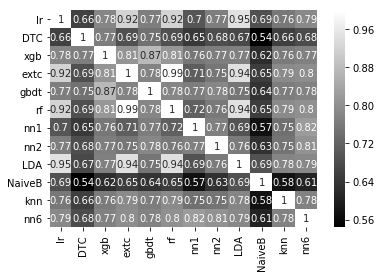

In [124]:
#First_level_prediction:
prediction_first_level = pd.DataFrame({'lr': pred1_lr, 'DTC': pred1_dtc, 'xgb': pred1_xgb,
                                      'extc': pred1_extc,'gbdt': pred1_gbdt, 'rf': pred1_rf, 'nn1':pred1_nn1,
                                      'nn2': pred1_nn2, 'LDA': pred1_LDA, 'NaiveB': pred1_naivb, 'knn': pred1_knn,
                                      'nn6': pred1_nn6})
prediction_first_level['nn1'] = [1 if t >= 0.5 else 0 for t in pred1_nn1]
prediction_first_level['nn2'] = [1 if t >= 0.5 else 0 for t in pred1_nn2]
prediction_first_level['nn6'] = [1 if t >= 0.5 else 0 for t in pred1_nn6]
#Check how similar the models are:
test_second_level = pd.DataFrame({'lr': test_lr,  'DTC': test_dtc, 'xgb': test_xgb,
                                 'extc': test_extc, 'gbdt': test_gbdt, 'rf': test_rf, 'nn1': test_nn1,
                                 'nn2': test_nn2, 'LDA': test_LDA, 'NaiveB': test_naivb, 'knn': test_knn,
                                 'nn6': test_nn6})
sns.heatmap(prediction_first_level.corr(), cmap = 'gray', annot = True)
###

In [148]:
#Generate the output by some specific weights:
#pred_label1: average of prediction for 12 models:
num_model = 12
weights_1 = np.repeat(1/num_model, num_model)
pred_label1 = np.dot(np.asarray(test_second_level), weights_1)
pred_label1 = [1 if t>0.5 else 0 for t in pred_label1]
#pred_label2: random sampling the weights:
weights_2 = np.random.choice(200, num_model)
weights_2 = weights_2 / np.sum(weights_2)
pred_label2 = np.dot(np.asarray(test_second_level), weights_2)
pred_label2 = [1 if t>0.5 else 0 for t in pred_label2]


In [149]:
test_df = pd.read_csv('test.csv')
IDtest = test_df['PassengerId']

In [150]:
#Generate the prediction:
test_Survived1 = pd.Series(pred_label1, name = 'Survived')
test_Survived2 = pd.Series(pred_label2, name = 'Survived')
results1 = pd.concat([IDtest, test_Survived1], axis = 1)
results1.to_csv('baseline_submission__1.csv', index = False)
results2 = pd.concat([IDtest, test_Survived2], axis = 1)
results2.to_csv('baseline_submission__2.csv', index = False)

In [ ]:
#This score for submission is 0.80912. I attach the submission in the zip.